# COVID 19 - Compartmental Model Simulation

<img src="COVIDbanner.png" width="1000"> 

## Model

The notebook introduces the compartmental stochastic model developed by Gareth et al. (2011)[https://arxiv.org/abs/1108.3137v1]. The COVID-19 model is using Bayesian methods to jointly estimate information from a stochastic mixing matrix that quantifies sexual interaction patterns by age and gender with parameters from a system of high-dimensional ODEs. This stochastic mixing matrix relies on quantities that are a priori unknown. 

The aims of our research is to evaluate the model under new conditions and also improve its inference time.

1. Explore the performance of the model under COVID-19 conditions
2. Improve the calibration time of the model by utilising Stochastic Approximate Inference Methods [Damianou et al.](https://arxiv.org/pdf/1409.2287.pdf).
3. Expand the model capacity by incorporating social mixing matrix methods, such as from POLYMOD and BBC Science [Diekmann et al.](https://royalsocietypublishing.org/doi/10.1098/rsif.2009.0386)

<img src="COVIDb.png" width="1000"> 

From the graph above, we define the following compartments:
- **$S$** is individuals who are at risks of Covid-19 infection
- **$I$** is infected individuals including asymptomatic and mild cases
- **$G$** is infected people who developed more severe cases of symptoms and required hospitalization
- **$P$** is those who recovered, and are seropositive and immune
- **$N$** is individuals who are recovered, immune but seronegative

We also introduce the attributes age ($a$), gender ($g$) and social activity group ($s$) differentiating individuals in a population.

- $a$ : age - is 5-year band
- $g$ : gender - male = 0, female = 1
- $s$ : social intereaction category - active = 1, not active = 0

$r = 5 * 365 = 1825$

$R = 2 * 2 * 1825 = 7300$

An important metric used to characterised the epidemic is $\mathcal{R}_0$ which is defined as:

$$
\mathcal{R}_0 = \tau \cdot \bar{c} \cdot d
$$

$\tau$ : the transmissibility (i.e., probability of infection given contact between a susceptible and infected individual)

$\bar{c}$ :  the average rate of contact between susceptible and infected individuals

$d$ : the duration of infectiousness

$\mathcal{R}_0$ is estimated to be between $2.76$ and $3.25$.

## Code

In [21]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)

STATES = ['S', 'I', 'G', 'P', 'N']

ages = np.arange(0, 101, 25, np.int32)

A_CATEGORIES = [str(t) for t in zip(ages, ages[1:])]
G_CATEGORIES = ["male", "female"]
S_CATEGORIES = ["high", "low"]

Based on the mixing matrix we derive the force of infection $\lambda$

\begin{equation}
\lambda_{g,s,a}=\beta_{g}\sum_{s^{'}, \alpha^{'}} \bigg\{ c^{*}_{g,s,s^{'},\alpha,\alpha^{'}} \frac{I_{g^{'}, s^{'}, \alpha{'}}}{S_{g^{'}, s^{'}, \alpha{'}} + I_{g^{'}, s^{'}, \alpha{'}} + G_{g^{'}, s^{'}, \alpha{'}} + P_{g^{'}, s^{'}, \alpha{'}} + N_{g^{'}, s^{'}, \alpha{'}} } \bigg\}
\end{equation}

In [22]:
def _np_divide_non_zero(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Force of infection lambda
def intensity(t, g, s, a, S, I, G, P, N, beta, c):
    opposite_group_ratio = _np_divide_non_zero(I, (S + I + G + P + N))
    infectious_interactions = np.sum(c[g,:, s,:, a,:] * opposite_group_ratio)
    return beta[g] * infectious_interactions

The script below describes the ODEs

\begin{align*}
\tag{1}
& \dot{S}_{g,s,a} & = & -\lambda_{g,s,a}(t)S_{g,s,a} + (P_{g,s,a} + N_{g,s,a})/DI_g + \frac{1}{r}S_{g,s,a-1} - \frac{1}{r}S_{g,s,a} + &\\
&&& \frac{1}{R}\sum_{g,s}(S_{g,s,20} + I_{g,s,20} + G_{g,s,20} + P_{g,s,20} + N_{g,s,20}) \times &\\
&&& \delta_1(a)(\pi_1\delta_1(s) + \pi_2\delta_2(s) + \pi_3\delta_3(s) + \pi_4\delta_4(s)) &\\ \\
\tag{2}
& \dot{I}_{g,s,a}  & = &  \lambda_{g,s,a}(t)S_{g,s,a} - (1/WIP_g + 1/DAI_g)I_{g,s,a} + \frac{1}{r}I_{g,s,a-1}-\frac{1}{r}I_{g,s,a} &\\ \\
\tag{3}
& \dot{G}_{g,s,a}  & = &  I_{g,s,a}/WIP_g - G_{g,s,a}/DWT_g + \frac{1}{r}G_{g,s,a-1} - \frac{1}{r}G_{g,s,a} &\\ \\ 
\tag{4}
& \dot{P}_{g,s,a}  & = &  PSC_g(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - P_{g,s,a}/DI_g + \frac{1}{r}P_{g,s,a-1} - \frac{1}{r}P_{g,s,a} &\\ \\
\tag{5}
& \dot{N}_{g,s,a}  & = &  (1-PSC_g)(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - N_{g,s,a}/DI_g + \frac{1}{r}N_{g,s,a-1}-\frac{1}{r}N_{g,s,a} &\\ \\
\end{align*}

In [23]:
def dS(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, di=None, sip=None, r=None, **kwargs):
    dSdt = - intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] + \
        (P[g, s, a] + N[g, s, a]) / di[g] - S[g, s, a] / r + int(bool(a)) * S[g, s, a-1] / r
    
    if a != 0:
        return dSdt
        
    R = len(G_CATEGORIES) * len(S_CATEGORIES)
    inflow = np.sum(
        np.sum([
            S[:,:,-1], 
            I[:,:,-1],
            G[:,:,-1],
            P[:,:,-1],
            N[:,:,-1]
        ]) * sip / r
    )
            
    return dSdt + inflow / R

def dI(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, wip=None, dai=None, r=None, **kwargs):
    dIdt = intensity(t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] - \
        (1/wip[g] + 1/dai[g]) * I[g, s, a] - I[g, s, a] / r + int(bool(a)) * I[g, s, a-1] / r
    
    return dIdt

def dG(t, g, s, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[g, s, a] / wip[g] - G[g, s, a] / dwt[g] - G[g, s, a] / r + int(bool(a)) * G[g, s, a-1] / r
    
    return dGdt

def dP(t, g, s, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - P[g, s, a] / di[g] - \
        P[g, s, a] / r + int(bool(a)) * P[g, s, a-1] / r
    
    return dPdt

def dN(t, g, s, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - \
        N[g, s ,a]/di[g] - N[g, s, a] / r + int(bool(a)) * N[g, s, a-1] / r
    
    return dNdt

In [24]:
DELTAS_FUNC = {
    "S": dS, "I": dI, "G": dG, "P": dP, "N": dN
}

def system(y, t, params, reshape_func):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    params = {k: v for k, v in zip(
        ["sip", "beta", "c", "di", "wip", "dai", "dwt", "psc", "r"], 
        deflatten_params(params))
    }
    
    states_ = reshape_func(y, (len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.empty((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }

    lengths = [len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)]
    
    ret = [None]*np.prod(lengths)
    for i_state, state in enumerate(STATES):
        for i_g in range(len(G_CATEGORIES)):
            for i_s in range(len(S_CATEGORIES)):
                for i_a in range(len(A_CATEGORIES)):
                    idx = np.dot(
                        [i_state, i_g, i_s, i_a], 
                        [np.prod(lengths[i:] + [1]) for i in range(1, len(lengths)+1)]
                    )
                    ret[idx] = DELTAS_FUNC[state](t, i_g, i_s, i_a, **states, **params)
                    
    return ret

In [25]:
def generate_initial_state(n=100, infected_ratio=0.5, seed=123):
    """Generate a random initial state
    
    Params:
        n (int): the population size
        infected_ratio (float): the ratio of people infected in the population
        seed (int): the random seed to use
    """
    np.random.seed(seed)
    
    ages = np.random.randint(len(A_CATEGORIES), size=n)
    genders = np.random.randint(len(G_CATEGORIES), size=n)
    social_interactions = np.random.randint(len(S_CATEGORIES), size=n)
    
    initial_states = {
        state: np.zeros((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }
    
    for i, (a, g, s) in enumerate(zip(ages, genders, social_interactions)):
        if i < int(n*infected_ratio):
            initial_states["I"][g, s, a] += 1
        else:
            initial_states["S"][g, s, a] += 1
            
    for state in STATES:
        initial_states[state] = initial_states[state].flatten()
        
    return np.concatenate(tuple(initial_states[state] for state in STATES))

In [26]:
def generate_social_interaction_matrix(flatten=False):
    ret = np.ones((
        len(G_CATEGORIES), len(G_CATEGORIES), 
        len(S_CATEGORIES), len(S_CATEGORIES),
        len(A_CATEGORIES), len(A_CATEGORIES)
    ))
    
    if flatten:
        return ret.flatten()
    return ret

In [27]:
def flatten_params(*params):
    return np.hstack([p.flatten() if isinstance(p, (np.ndarray,)) else p for p in params])

def deflatten_params(params):
    shapes = np.array([
        (len(S_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES), len(G_CATEGORIES), len(S_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES), len(A_CATEGORIES)),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (2,),
        1
    ])
    
    length_parameters = [
        np.prod(s) if s != 1 else s
        for s in shapes
    ]
    
    split_indices = np.cumsum(length_parameters)
    
    return tuple(
        a.reshape(s) if s != 1 else a[0] 
        for s, a in zip(shapes, np.split(params, split_indices[:-1]))
    )

In [28]:
state0 = generate_initial_state()
t = np.linspace(0, 100, 101)

args = flatten_params(*(
    tfd.Dirichlet(np.ones((len(S_CATEGORIES),))).sample(),                  # sip
    tfd.Beta(3, 2).sample(2),                  # beta
    generate_social_interaction_matrix(),  # c
    tfd.Exponential(1/2).sample(len(G_CATEGORIES)),                      # di
    tfd.Exponential(1/7).sample(len(G_CATEGORIES)),                      # wip
    tfd.Exponential(1/3).sample(len(G_CATEGORIES)),                      # dai
    tfd.Exponential(1/14).sample(len(G_CATEGORIES)),                    # dwt
    tfd.Dirichlet(np.ones((len(G_CATEGORIES),))).sample(),                  # psc
    1825.,                                 # r
))


class CompartmentModel(object):
    
    def __init__(self, times, state0=None):
        self.times = times
        self.state0 = state0 if state0 is not None else generate_initial_state()
        
    def run(self, *args):
        return odeint(system, state0, t, args=(args, self._reshape_func), rtol=1e-6, atol=1e-6)
    
    @staticmethod
    def _reshape_func(a, shape):
        return a.reshape(shape)
    
    @staticmethod
    def _build_history(sol):
        """Reconstruct the history from the output of the ODE solver

        Params:
            sol (array): the output of the ODE solver

        Returns:
            hist (array): the array of shape (len(t), len(G), len(S), len(A))
        """
        hists = {
            state: [] for state in STATES
        }

        for t, states_t in enumerate(sol):
            for state, vals in zip(STATES, np.array_split(states_t, len(STATES))):
                hists[state].append(
                    vals.reshape((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
                )

        return {s : np.array(h) for s, h in hists.items()}
    
    def plot(self, sol, gender, social_interaction, age, obs=None):
        G = G_CATEGORIES.index(gender)
        S = S_CATEGORIES.index(social_interaction)
        A = A_CATEGORIES.index(age)

        plt.figure(figsize=(20,10))

        if obs is not None:
            obs_hists = self._build_history(obs)
            plt.plot(self.times[1:], obs_hists["S"][:, G, S, A], marker='o', color="C0", linestyle='none')
            plt.plot(self.times[1:], obs_hists["I"][:, G, S, A], marker='o', color="C1", linestyle='none')
            plt.plot(self.times[1:], obs_hists["G"][:, G, S, A], marker='o', color="C2", linestyle='none')
            plt.plot(self.times[1:], obs_hists["P"][:, G, S, A], marker='o', color="C3", linestyle='none')
            plt.plot(self.times[1:], obs_hists["N"][:, G, S, A], marker='o', color="C4", linestyle='none')

        hists = self._build_history(sol)
        plt.plot(self.times, hists["S"][:, G, S, A], color="C0", label=f'$S(t)$')
        plt.plot(self.times, hists["I"][:, G, S, A], color="C1", label=f'$I(t)$')
        plt.plot(self.times, hists["G"][:, G, S, A], color="C2", label=f'$G(t)$')
        plt.plot(self.times, hists["P"][:, G, S, A], color="C3", label=f'$P(t)$')
        plt.plot(self.times, hists["N"][:, G, S, A], color="C4", label=f'$N(t)$')

        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

model = CompartmentModel(t, state0)
sol = model.run(*args)

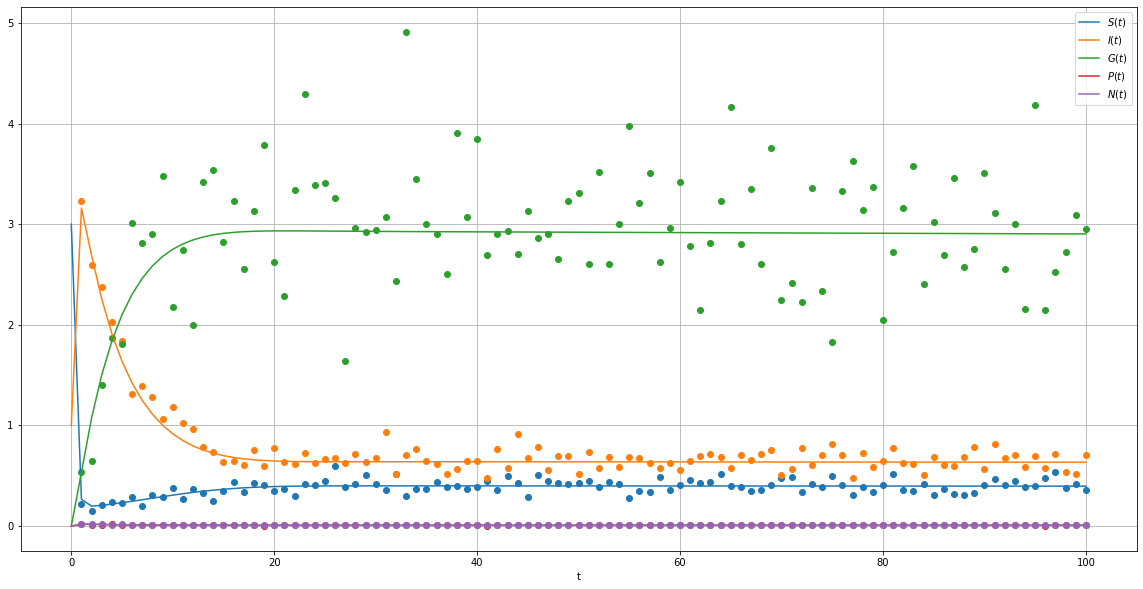

In [29]:
# Observational model
np.random.seed(123)

obs = np.random.lognormal(
    mean=np.log(sol[1::]), 
    sigma=np.random.uniform(0.1, 0.3, size=sol.shape[1])
)
    
model.plot(sol, "male", "high", "(25, 50)", obs=obs)

In [30]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [31]:
def func(t, y):
    return tf.Variable(system(y, t, args, tf.reshape))

results = tfp.math.ode.BDF().solve(func, 0, state0, solution_times=t[:25])



Variational Inference (VI) methods are used to identify complex distributions as an alternative to the computationally costly (but very accurate) Markov chain Monte Carlo (MCMC) sampling. In general, MCMC provide guarantees of producing (asymptotically) exact samples from the target density [4, p.3]. In VI case, we use a less complex but still flexible **family** of distributions to approximate an intractable distribution. Some literature works on VI are

1. Information Theory, Inference and Learning Algorithms, David J. C. MacKay, David J. C. Mac Kay, Cambridge University Press, 2003
2. Bayesian Reasoning and Machine Learning, David Barber, Cambridge University Press, 2012
3. Pattern Recognition and Machine Learning, Christopher M. Bishop, Springer New York, 2016
4. Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe, 2018
5. High-Level Explanation of Variational Inference, Jason Eisner, 2011

For business and academic projects, where Bayesian models are fitted on very large datasets (Big Data applications), approximate inference methods are a very efficient and optimised way of infering quite accurate results.


Assume that we want to use VI on a Bayesian regression, let $x$ be the independent variables with $X$ their matrix form and $y$ the continuous responce variable. The coefficients $\beta$ of the model follow a complex multimodal distribution. 

$$
y = \mathcal{N}(\beta^{T}X, \sigma^{2})
$$

in Bayesian form, we want to infer the posterior of the model, in other words the distribution of the coefficients

$$
p(\beta|y, X) = \frac{p(y|X, \beta)p(\beta|X)}{p(y)}
$$

The complexity of the posterior distribution means that we have two ways to compute the results

1. Use MCMC sampling methods (Gibb's, Hamiltonian)
2. Use approximate methods

To use approximate inference we follow the steps, that are similar to [1, 2, 4]

$$
\begin{align}
KL(q(\beta)||p(\beta|y, X)) &= \int d\beta q(\beta) log \frac{q(\beta)}{p(\beta|y, X)}\\
&= \int d\beta q(\beta) log q(\beta) - \int d\beta q(\beta) log p(\beta|y, X) \\
&= \int d\beta q(\beta) log q(\beta) - \int d\beta q(\beta) log \frac{p(y|\beta, X)p(\beta|X)}{p(y)} \\
&= \int d\beta q(\beta) log q(\beta) - \int d\beta q(\beta) log p(y|\beta, X)p(\beta|X) + log p(y) \\
&= \int d\beta q(\beta) log q(\beta) - \int d\beta q(\beta) log p(y|\beta, X) - \int q(\beta) log p(\beta|X) + log p(y) \\
&= \int d\beta q(\beta) log q(\beta) - \int d\beta q(\beta) log p(\beta|X) - \int q(\beta) log p(y|\beta, X) + log p(y) \\
&= \int d\beta q(\beta) log \frac{q(\beta)}{p(\beta|X)} - \int d\beta q(\beta) log p(y|\beta, X) + log p(y) \\
&= KL(q(\beta)||p(\beta|X)) - \mathbb{E}_{q}(log p(y|\beta, X)) + log p(y)
\end{align}
$$

the RHS of the equation shows the entropy, the average energy and the evidence (marginal of $y$).
By setting the lower bound (and change the signs because we move the $log p(y)$ on the LHS) as

$$
ELBO(q) = \mathbb{E}_{q}(log p(y|\beta, X)) - KL(q(\beta)||p(\beta|X))
$$

and the previous formula becomes

$$
log p(y) = ELBO(q) + KL(q(\beta)||p(\beta|y, X))
$$

which is similar to the formula that Bishop has in his book [3, p.463]

In [32]:
sigma = tfd.HalfCauchy(
    1, scale=1, name='HalfCauchy'
)

In [33]:
scale_HC = tf.dtypes.cast(sigma.sample(state0.shape[0]), tf.float32)
score = tf.dtypes.cast(results[3][0][0], tf.float32)

In [34]:
def log_prob(z, x):
  return tfd.MultivariateNormalDiag(score, scale_diag=scale_HC).log_prob(z) + \
tfd.Normal(tf.reduce_mean(z), scale=1).log_prob(x)
conditioned_log_prob = lambda z: log_prob(z, x=obs.astype("float32"))

In [35]:
q_z = tfd.Normal(loc=tf.Variable(0., name='q_z_loc'),
                 scale=tfp.util.TransformedVariable(1., tfp.bijectors.Softplus(),
                                                    name='q_z_scale'),
                 name='q_z')
losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior=q_z,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=10000)

print(q_z.sample(), q_z.stddev())

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
tf.Tensor(1.1945138, shape=(), dtype=float32) tf.Tensor(0.21132714, shape=(), dtype=float32)


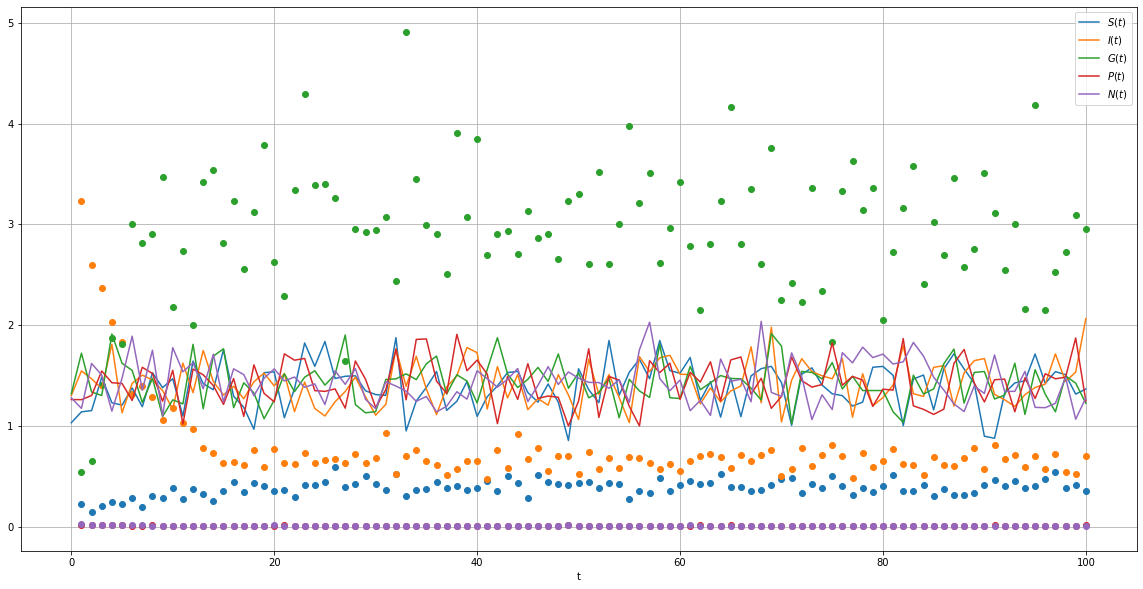

In [36]:
model.plot(tfd.Sample(tfd.Independent(q_z, reinterpreted_batch_ndims=0), sample_shape=[80]).sample(101), "male", "high", "(25, 50)", obs=obs) 

In [155]:
generate_social_interaction_matrix().shape

(2, 2, 2, 2, 4, 4)

## Simulation

TODO